In [210]:
import pandas as pd
import math
import numpy as np
from seqeval.metrics import f1_score
from seqeval.metrics import classification_report,accuracy_score,f1_score
import torch.nn.functional as F

In [228]:
import torch
import os
from tqdm import tqdm,trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertConfig
from transformers import BertForTokenClassification, AdamW

### Introduction
In this notebook, will introduce how to do NER with BERT, including:

* Load and preprocess data
* Parser data
* Make training data
* Train model
* Evaluate result
* Inference

Tips:

* Update to transformer==2.5.1
* When come across OOV,you will find that BERT word piece tokenize method can help a lot
* Case model will be litter better than uncase model for English

Also this notebook come with a post NER with BERT in Action (https://medium.com/@yingbiao/ner-with-bert-in-action-936ff275bc73)

### Load data
Load CSV data

In [229]:
# Fillna method can make same sentence with same sentence name
df_data = pd.read_csv("D:/DataAnalysis/Python/BERT/ner_dataset.csv/ner_dataset.csv",sep=",",encoding="latin1").fillna(method='ffill')

In [250]:
df_data.head(n=40)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [231]:
df_data.columns

Index(['Sentence #', 'Word', 'POS', 'Tag'], dtype='object')

#### Have a look POS cat

In [232]:
#df_data.POS.unique()

#### Have a look TAG cat

In [233]:
df_data.Tag.unique()

array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [234]:
# Analyse summary of data
df_data['Sentence #'].nunique(), df_data.Word.nunique(), df_data.POS.nunique(), df_data.Tag.nunique()

(47959, 35178, 42, 17)

In [235]:
# Analyse the Tag distribution
df_data.Tag.value_counts()

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64

#### Explain tag
As show above, there are two parts for the tag name: "position"-"meaning"

* B: begin, word at the first position
* I: middle, word not at the first position,especially for phase
* time: time, meaning time
* per: person, meaning people name
* geo: geography, meaning location name
* O: mean other, set as a default tag

### Parser data
Parser data into document structure

Since we will treat the NER process as a multi-class classification, we need to make the training data into “token-label” form, we need to parser the sentence from data set. So that we can get lists of token and label.

In [236]:
class SentenceGetter(object):
    
    def __init__(self, data):
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["Word"].values.tolist(),
                                                           s["POS"].values.tolist(),
                                                           s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

#### Lets get lists of token and label

In [238]:
# Get full document data structure
getter = SentenceGetter(df_data)

In [239]:
# Get sentence data
sentences = [[s[0] for s in sent] for sent in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [240]:
sentences[1]

['Iranian',
 'officials',
 'say',
 'they',
 'expect',
 'to',
 'get',
 'access',
 'to',
 'sealed',
 'sensitive',
 'parts',
 'of',
 'the',
 'plant',
 'Wednesday',
 ',',
 'after',
 'an',
 'IAEA',
 'surveillance',
 'system',
 'begins',
 'functioning',
 '.']

In [241]:
# Get pos data
#poses = [[s[1] for s in sent] for sent in getter.sentences]
#print(poses[0])

In [242]:
# Get tag labels data
labels = [[s[2] for s in sent] for sent in getter.sentences]
print(labels[0])

['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'B-gpe', 'O', 'O', 'O', 'O', 'O']


In [243]:
print(labels[1])

['B-gpe', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-tim', 'O', 'O', 'O', 'B-org', 'O', 'O', 'O', 'O', 'O']


#### Make TAG name into index for training

In [32]:
tags_vals = list(set(df_data["Tag"].values))

In [33]:
# Add X  label for word piece support
# Add [CLS] and [SEP] as BERT need
tags_vals.append('X')
tags_vals.append('[CLS]')
tags_vals.append('[SEP]')

In [34]:
tags_vals = set(tags_vals)

In [35]:
tags_vals

{'B-art',
 'B-eve',
 'B-geo',
 'B-gpe',
 'B-nat',
 'B-org',
 'B-per',
 'B-tim',
 'I-art',
 'I-eve',
 'I-geo',
 'I-gpe',
 'I-nat',
 'I-org',
 'I-per',
 'I-tim',
 'O',
 'X',
 '[CLS]',
 '[SEP]'}

In [36]:
# Set a dict for mapping id to tag name
#tag2idx = {t: i for i, t in enumerate(tags_vals)}

# Recommend to set it by manual define, good for reusing
tag2idx={'B-art': 14,
 'B-eve': 16,
 'B-geo': 0,
 'B-gpe': 13,
 'B-nat': 12,
 'B-org': 10,
 'B-per': 4,
 'B-tim': 2,
 'I-art': 5,
 'I-eve': 7,
 'I-geo': 15,
 'I-gpe': 8,
 'I-nat': 11,
 'I-org': 3,
 'I-per': 6,
 'I-tim': 1,
 'X':17,
 'O': 9,
 '[CLS]':18,
 '[SEP]':19}

In [37]:
tag2idx

{'B-art': 14,
 'B-eve': 16,
 'B-geo': 0,
 'B-gpe': 13,
 'B-nat': 12,
 'B-org': 10,
 'B-per': 4,
 'B-tim': 2,
 'I-art': 5,
 'I-eve': 7,
 'I-geo': 15,
 'I-gpe': 8,
 'I-nat': 11,
 'I-org': 3,
 'I-per': 6,
 'I-tim': 1,
 'X': 17,
 'O': 9,
 '[CLS]': 18,
 '[SEP]': 19}

In [38]:
# Mapping index to name
tag2name={tag2idx[key] : key for key in tag2idx.keys()}

In [39]:
tag2name

{14: 'B-art',
 16: 'B-eve',
 0: 'B-geo',
 13: 'B-gpe',
 12: 'B-nat',
 10: 'B-org',
 4: 'B-per',
 2: 'B-tim',
 5: 'I-art',
 7: 'I-eve',
 15: 'I-geo',
 8: 'I-gpe',
 11: 'I-nat',
 3: 'I-org',
 6: 'I-per',
 1: 'I-tim',
 17: 'X',
 9: 'O',
 18: '[CLS]',
 19: '[SEP]'}

### Make training data
Make raw data into trainable data for BERT, including:

1) Set gpu environment

2) Load tokenizer and tokenize

3) Set 3 embedding, token embedding, mask word embedding, segmentation embedding

4) Split data set into train and validate, then send them to dataloader

#### Preprocessing the data

Before we can feed those texts to our model, we need to preprocess them. This is done by a Transformers Tokenizer which will (as the name indicates) tokenize the inputs (including converting the tokens to their corresponding IDs in the pretrained vocabulary) and put it in a format the model expects, as well as generate the other inputs that model requires.

To do all of this, we instantiate our tokenizer with the AutoTokenizer.from_pretrained method, which will ensure:

we get a tokenizer that corresponds to the model architecture we want to use, we download the vocabulary used when pretraining this specific checkpoint. That vocabulary will be cached, so it's not downloaded again the next time we run the cell.

#### 1) Set up gpu environment

In [43]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
n_cpu = torch.cuda.device_count()

In [44]:
n_gpu

0

#### 2) Load tokenizer
You can download the tokenizer file into local folder first :

In [46]:
# Manual define vocabulary address, if you download the tokenzier file in local
# vocab.txt, download from: https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-vocab.txt
vocabulary = "D:/DataAnalysis/Python/BERT/bert-base-cased-vocab.txt"

In [47]:
# Len of the sentence must be not bigger than the training model
# See model's 'max_position_embeddings' = 512
max_len  = 45

In [48]:
# load tokenizer, with manual file address or pretrained address
tokenizer=BertTokenizer(vocab_file=vocabulary,do_lower_case=False)

#### Tokenizer text

1) In hunggieface for bert, when come across OOV, will word piece the word

Note: Note that transformers are often pretrained with subword tokenizers, meaning that even if your inputs have been split into words already, each of those words could be split again by the tokenizer. Let's look at an example of that as shown in below fig.

Note: This means that we need to do some processing on our labels as the input ids returned by the tokenizer are longer than the lists of labels our dataset contain, first because some special tokens might be added (we can a [CLS] and a [SEP] above) and then because of those possible splits of words in multiple tokens:

2) We need to adjust the labels base on the tokenize result, “##abc” need to set label "X"

3) Need to set "[CLS]" at front and "[SEP]" at the end, as what the paper do, BERT indexer should add [CLS] and [SEP] tokens

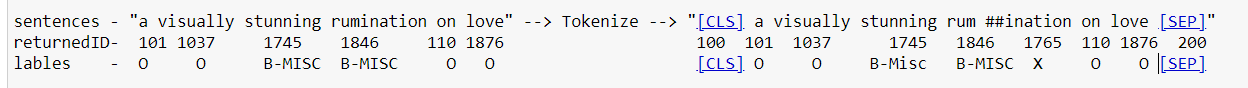

In [257]:
from IPython.display import Image
Image(filename = 'D:/DataAnalysis/Python/BERT/Capture1.PNG', width = 1000, height = 1000)

In [49]:
tokenized_texts = []
word_piece_labels = []
i_inc = 0
for word_list,label in (zip(sentences,labels)):
    temp_lable = []
    temp_token = []
    
    # Add [CLS] at the front 
    temp_lable.append('[CLS]')
    temp_token.append('[CLS]')
    
    for word,lab in zip(word_list,label):
        token_list = tokenizer.tokenize(word)
        for m,token in enumerate(token_list):
            temp_token.append(token)
            if m==0:
                temp_lable.append(lab)
            else:
                temp_lable.append('X')  
                
    # Add [SEP] at the end
    temp_lable.append('[SEP]')
    temp_token.append('[SEP]')
    
    tokenized_texts.append(temp_token)
    word_piece_labels.append(temp_lable)
    
    if 5 > i_inc:
        print("No.%d,len:%d"%(i_inc,len(temp_token)))
        print("texts:%s"%(" ".join(temp_token)))
        print("No.%d,len:%d"%(i_inc,len(temp_lable)))
        print("lables:%s"%(" ".join(temp_lable)))
    i_inc +=1

No.0,len:28
texts:[CLS] Thousands of demons ##tra ##tors have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country . [SEP]
No.0,len:28
lables:[CLS] O O O X X O O O B-geo O O O O O B-geo O O O O O B-gpe O O O O O [SEP]
No.1,len:29
texts:[CLS] Iranian officials say they expect to get access to sealed sensitive parts of the plant Wednesday , after an I ##A ##EA surveillance system begins functioning . [SEP]
No.1,len:29
lables:[CLS] B-gpe O O O O O O O O O O O O O O B-tim O O O B-org X X O O O O O [SEP]
No.2,len:44
texts:[CLS] He ##lic ##op ##ter guns ##hips Saturday pounded militant hide ##outs in the Or ##ak ##zai tribal region , where many Taliban militants are believed to have fled to avoid an earlier military offensive in nearby South W ##azi ##rist ##an . [SEP]
No.2,len:44
lables:[CLS] O X X X O X B-tim O O O X O O B-geo X X O O O O O B-org O O O O O O O O O O O O O O B-geo I-geo X X X O [SEP]
No.3,len:16
texts:[CLS] They lef

#### Set token embedding
Pad or trim the text and label to fit the need for max len

In [50]:
# Make text token into id
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=max_len, dtype="long", truncating="post", padding="post")
print(input_ids[0])

[  101 26159  1104  8568  4487  5067  1138  9639  1194  1498  1106  5641
  1103  1594  1107  5008  1105  4555  1103 10602  1104  1418  2830  1121
  1115  1583   119   102     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0]


In [51]:
# Make label into id, pad with "O" meaning others
tags = pad_sequences([[tag2idx.get(l) for l in lab] for lab in word_piece_labels],
                     maxlen=max_len, value=tag2idx["O"], padding="post",
                     dtype="long", truncating="post")
print(tags[0])

[18  9  9  9 17 17  9  9  9  0  9  9  9  9  9  0  9  9  9  9  9 13  9  9
  9  9  9 19  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9  9]


#### Set mask word embedding
In order to make mask word embedding, we need to use 1 to indicate the real token and 0 to indicate to pad token:

In [259]:
# For fine tune of predict, with token mask is 1,pad token is 0
attention_masks = [[int(i>0) for i in ii] for ii in input_ids]
print(attention_masks[0]);

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### Set segment embedding(Seem like for sequance tagging task, it's not necessary to make this embedding)

In [54]:
# Since only one sentence, all the segment set to 0
segment_ids = [[0] * len(input_id) for input_id in input_ids]
segment_ids[0];

#### Split data into train and validate
70% for training, 30% for validation

In [55]:
tr_inputs, val_inputs, tr_tags, val_tags,tr_masks, val_masks,tr_segs, val_segs = train_test_split(input_ids, tags,attention_masks,segment_ids, 
                                                            random_state=4, test_size=0.3)

In [56]:
len(tr_inputs),len(val_inputs),len(tr_segs),len(val_segs)

(33571, 14388, 33571, 14388)

#### Set data into tensor

Not recommend tensor.to(device) at this process, since it will run out of GPU memory

In [57]:
tr_inputs = torch.tensor(tr_inputs)
val_inputs = torch.tensor(val_inputs)
tr_tags = torch.tensor(tr_tags)
val_tags = torch.tensor(val_tags)
tr_masks = torch.tensor(tr_masks)
val_masks = torch.tensor(val_masks)
tr_segs = torch.tensor(tr_segs)
val_segs = torch.tensor(val_segs)

#### Put data into data loader

In [58]:
# Set batch num
batch_num = 32

In [59]:
# Only set token embedding, attention embedding, no segment embedding
train_data = TensorDataset(tr_inputs, tr_masks, tr_tags)
train_sampler = RandomSampler(train_data)
# Drop last can make batch training better for the last one
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_num,drop_last=True)

valid_data = TensorDataset(val_inputs, val_masks, val_tags)
valid_sampler = SequentialSampler(valid_data)
valid_dataloader = DataLoader(valid_data, sampler=valid_sampler, batch_size=batch_num)

#### Train model
You can download the model require files into local folder first

pytorch_model.bin: pytorch_model.bin

config.json: config.json

#### Load BERT model

In [78]:
# In this folder, contain model confg(json) and model weight(bin) files
# pytorch_model.bin, download from: https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-pytorch_model.bin
# config.json, downlaod from: https://s3.amazonaws.com/models.huggingface.co/bert/bert-base-cased-config.json
model_file_address = 'D:/DataAnalysis/Python/BERT/bert-base-cased'

In [79]:
# Will load config and weight with from_pretrained()
model = BertForTokenClassification.from_pretrained(model_file_address,num_labels=len(tag2idx))

Some weights of the model checkpoint at D:/DataAnalysis/Python/BERT/bert-base-cased were not used when initializing BertForTokenClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model

In [80]:
model;

In [82]:
# Set epoch and grad max num
epochs = 5
max_grad_norm = 1.0

In [83]:
# Cacluate train optimiazaion num
num_train_optimization_steps = int( math.ceil(len(tr_inputs) / batch_num) / 1) * epochs

### Set fine tuning method

#### Manual optimizer

In [84]:
# True: fine tuning all the layers 
# False: only fine tuning the classifier layers
FULL_FINETUNING = True

In [85]:
if FULL_FINETUNING:
    # Fine tune model all layer parameters
    param_optimizer = list(model.named_parameters())
    no_decay = ['bias', 'gamma', 'beta']
    optimizer_grouped_parameters = [
        {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.01},
        {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
         'weight_decay_rate': 0.0}
    ]
else:
    # Only fine tune classifier parameters
    param_optimizer = list(model.classifier.named_parameters()) 
    optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]
optimizer = AdamW(optimizer_grouped_parameters, lr=3e-5)

### Fine-tuning model

In [86]:
# TRAIN loop
model.train();

b_labels = b_labels.type(torch.LongTensor)

In [90]:
print("***** Running training *****")
print("  Num examples = %d"%(len(tr_inputs)))
print("  Batch size = %d"%(batch_num))
print("  Num steps = %d"%(num_train_optimization_steps))
for _ in trange(epochs,desc="Epoch"):
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0
    for step, batch in enumerate(train_dataloader):
        # add batch to gpu
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        ###############Bug fix code####################
        b_input_ids = b_input_ids.type(torch.LongTensor)
        b_input_mask = b_input_mask.type(torch.LongTensor)
        b_labels = b_labels.type(torch.LongTensor)

        b_input_ids = b_input_ids.to(device)
        b_input_mask = b_input_mask.to(device)
        b_labels = b_labels.to(device)
         ############################################
        
        # forward pass
        outputs = model(b_input_ids, token_type_ids=None,
        attention_mask=b_input_mask, labels=b_labels)
        loss, scores = outputs[:2]
        if n_gpu>1:
            # When multi gpu, average it
            loss = loss.mean()
        
        # backward pass
        loss.backward()
        
        # track train loss
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1
        
        # gradient clipping
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
        
        # update parameters
        optimizer.step()
        optimizer.zero_grad()
        
    # print train loss per epoch
    print("Train loss: {}".format(tr_loss/nb_tr_steps))

Epoch:   0%|                                                                                     | 0/5 [00:00<?, ?it/s]

***** Running training *****
  Num examples = 33571
  Batch size = 32
  Num steps = 5250


Epoch:  20%|██████████████▏                                                        | 1/5 [1:52:22<7:29:28, 6742.14s/it]

Train loss: 0.1427163745217146


Epoch:  40%|████████████████████████████▍                                          | 2/5 [3:44:35<5:36:58, 6739.45s/it]

Train loss: 0.06796318564290542


Epoch:  60%|██████████████████████████████████████████▌                            | 3/5 [5:36:59<3:44:41, 6740.79s/it]

Train loss: 0.05254879844303041


Epoch:  80%|████████████████████████████████████████████████████████▊              | 4/5 [7:23:40<1:50:38, 6638.81s/it]

Train loss: 0.0395832733056722


Epoch: 100%|█████████████████████████████████████████████████████████████████████████| 5/5 [9:11:51<00:00, 6622.22s/it]

Train loss: 0.02997857703515697


### Save model

In [91]:
bert_out_address = 'models/bert_out_model/en09'

In [92]:
# Make dir if not exits
if not os.path.exists(bert_out_address):
        os.makedirs(bert_out_address)

In [93]:
# Save a trained model, configuration and tokenizer
model_to_save = model.module if hasattr(model, 'module') else model  # Only save the model it-self

In [94]:
# If we save using the predefined names, we can load using `from_pretrained`
output_model_file = os.path.join(bert_out_address, "pytorch_model.bin")
output_config_file = os.path.join(bert_out_address, "config.json")

In [95]:
# Save model into file
torch.save(model_to_save.state_dict(), output_model_file)
model_to_save.config.to_json_file(output_config_file)
tokenizer.save_vocabulary(bert_out_address)

('models/bert_out_model/en09\\vocab.txt',)

### Load model

In [96]:
model = BertForTokenClassification.from_pretrained(bert_out_address,num_labels=len(tag2idx))

### Eval model

In [97]:
# Evalue loop
model.eval();

In [100]:
eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0
y_true = []
y_pred = []

print("***** Running evaluation *****")
print("  Num examples ={}".format(len(val_inputs)))
print("  Batch size = {}".format(batch_num))
for step, batch in enumerate(valid_dataloader):
    batch = tuple(t.to(device) for t in batch)
    input_ids, input_mask, label_ids = batch
    
    #b_input_ids = torch.tensor(b_input_ids).to(torch.int64)
    
#     if step > 2:
#         break

    ###############Bug fix code####################
    input_ids = input_ids.type(torch.LongTensor)
    input_mask = input_mask.type(torch.LongTensor)
    label_ids = label_ids.type(torch.LongTensor)

    input_ids = input_ids.to(device)
    input_mask = input_mask.to(device)
    labels = label_ids.to(device)
    ############################################
    
    with torch.no_grad():
        outputs = model(input_ids, token_type_ids=None,
        attention_mask=input_mask,)
        # For eval mode, the first result of outputs is logits
        logits = outputs[0] 
    
    # Get NER predict result
    logits = torch.argmax(F.log_softmax(logits,dim=2),dim=2)
    logits = logits.detach().cpu().numpy()
    
    
    # Get NER true result
    label_ids = label_ids.to('cpu').numpy()
    
    
    # Only predict the real word, mark=0, will not calculate
    input_mask = input_mask.to('cpu').numpy()
    
    # Compare the valuable predict result
    for i,mask in enumerate(input_mask):
        # Real one
        temp_1 = []
        # Predict one
        temp_2 = []
        
        for j, m in enumerate(mask):
            # Mark=0, meaning its a pad word, dont compare
            if m:
                if tag2name[label_ids[i][j]] != "X" and tag2name[label_ids[i][j]] != "[CLS]" and tag2name[label_ids[i][j]] != "[SEP]" : # Exclude the X label
                    temp_1.append(tag2name[label_ids[i][j]])
                    temp_2.append(tag2name[logits[i][j]])
            else:
                break
        
            
        y_true.append(temp_1)
        y_pred.append(temp_2)

        

print("f1 socre: %f"%(f1_score(y_true, y_pred)))
print("Accuracy score: %f"%(accuracy_score(y_true, y_pred)))

# Get acc , recall, F1 result report
report = classification_report(y_true, y_pred,digits=4)

# Save the report into file
output_eval_file = os.path.join(bert_out_address, "eval_results.txt")
with open(output_eval_file, "w") as writer:
    print("***** Eval results *****")
    print("\n%s"%(report))
    print("f1 socre: %f"%(f1_score(y_true, y_pred)))
    print("Accuracy score: %f"%(accuracy_score(y_true, y_pred)))
    
    writer.write("f1 socre:\n")
    writer.write(str(f1_score(y_true, y_pred)))
    writer.write("\n\nAccuracy score:\n")
    writer.write(str(accuracy_score(y_true, y_pred)))
    writer.write("\n\n")  
    writer.write(report)

***** Running evaluation *****
  Num examples =14388
  Batch size = 32


C:\Users\abhij\Anaconda3\lib\site-packages\seqeval\metrics\sequence_labeling.py:171: UserWarning: X seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


f1 socre: 0.833632
Accuracy score: 0.971210


C:\Users\abhij\Anaconda3\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


***** Eval results *****

              precision    recall  f1-score   support

           _     0.0000    0.0000    0.0000         0
         art     0.2025    0.1221    0.1524       131
         eve     0.3431    0.3846    0.3627        91
         geo     0.8594    0.8928    0.8758     11066
         gpe     0.9494    0.9480    0.9487      4830
         nat     0.6571    0.4694    0.5476        49
         org     0.6820    0.7143    0.6978      5954
         per     0.7708    0.7882    0.7794      5123
         tim     0.8594    0.8775    0.8683      6016

   micro avg     0.8226    0.8449    0.8336     33260
   macro avg     0.5915    0.5774    0.5814     33260
weighted avg     0.8227    0.8449    0.8336     33260

f1 socre: 0.833632
Accuracy score: 0.971210


### Inference
After we trained a model, we can make it into service ---- sending a new sentence to the model,then get the prediction.

The process contains:

* Load model
* Load tokenizer
* Set test query (Prediction on new sentences)
* Make query into embedding
* Predict with model
* Parser result

### Set tag index

In [101]:
# Tag to index, must be the same as we training
tag2idx={'B-art': 14,
 'B-eve': 16,
 'B-geo': 0,
 'B-gpe': 13,
 'B-nat': 12,
 'B-org': 10,
 'B-per': 4,
 'B-tim': 2,
 'I-art': 5,
 'I-eve': 7,
 'I-geo': 15,
 'I-gpe': 8,
 'I-nat': 11,
 'I-org': 3,
 'I-per': 6,
 'I-tim': 1,
 'X':17,
 'O': 9,
 '[CLS]':18,
 '[SEP]':19}

In [102]:
# Mapping index to name
tag2name={tag2idx[key] : key for key in tag2idx.keys()}

### Load model

In [103]:
# Model we trained before, the dir containing pytorch_model.bin and vocab.txt
save_model_address = 'models/bert_out_model/en09'

In [104]:
save_model = BertForTokenClassification.from_pretrained(save_model_address,num_labels=len(tag2idx))

### Load Tokenizer

In [105]:
# Here, our save model address containing pytorch_model.bin and vocab.txt
# So, we can load the tokenzier from the same dir as the save model address
tokenizer = BertTokenizer.from_pretrained(save_model_address,do_lower_case=False)

In [106]:
# Set max sentence length, must be the same as our training process
max_len  = 45

#### Set test query

In [178]:
test_query = "My name is Abhijeet, I am from India but currently live in USA, this is my Office laptop."

### Make query into embeddings

* token id embedding, need to tokenize first
* mask word embedding
* segmentation embedding

In [179]:
tokenized_texts = []
temp_token = []

In [180]:
# Add [CLS] at the front 
temp_token.append('[CLS]')

In [181]:
token_list = tokenizer.tokenize(test_query)

In [182]:
token_list

['My',
 'name',
 'is',
 'A',
 '##b',
 '##hi',
 '##jee',
 '##t',
 ',',
 'I',
 'am',
 'from',
 'India',
 'but',
 'currently',
 'live',
 'in',
 'USA',
 ',',
 'this',
 'is',
 'my',
 'Office',
 'laptop',
 '.']

In [183]:
for m,token in enumerate(token_list):
    temp_token.append(token)

In [184]:
# Trim the token to fit the length requirement
if len(temp_token) > max_len-1:
    temp_token= temp_token[:max_len-1]

In [185]:
# Add [SEP] at the end
temp_token.append('[SEP]')

In [186]:
temp_token

['[CLS]',
 'My',
 'name',
 'is',
 'A',
 '##b',
 '##hi',
 '##jee',
 '##t',
 ',',
 'I',
 'am',
 'from',
 'India',
 'but',
 'currently',
 'live',
 'in',
 'USA',
 ',',
 'this',
 'is',
 'my',
 'Office',
 'laptop',
 '.',
 '[SEP]']

In [187]:
tokenized_texts.append(temp_token)

#### Make id embedding

In [188]:
# Make text token into id
input_ids = pad_sequences([tokenizer.convert_tokens_to_ids(txt) for txt in tokenized_texts],
                          maxlen=max_len, dtype="long", truncating="post", padding="post")
print(input_ids[0])

[  101  1422  1271  1110   138  1830  3031 24260  1204   117   146  1821
  1121  1726  1133  1971  1686  1107  3066   117  1142  1110  1139  3060
 12574   119   102     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0]


#### Make mask embedding

In [189]:
# For fine tune of predict, with token mask is 1,pad token is 0
attention_masks = [[int(i>0) for i in ii] for ii in input_ids]
attention_masks[0];

#### Make segmention type embedding

In [190]:
segment_ids = [[0] * len(input_id) for input_id in input_ids]
segment_ids[0];

#### Make embeddings into torch tensor

In [191]:
input_ids = torch.tensor(input_ids)
attention_masks = torch.tensor(attention_masks)
segment_ids = torch.tensor(segment_ids)

#### Predict with model
We only send input_ids embedding to model

In [192]:
# Set save model to Evalue loop
save_model.eval();

In [195]:
# Get model predict result

with torch.no_grad():
        outputs = save_model(input_ids, token_type_ids=None,
        attention_mask=None,)
           
        # For eval mode, the first result of outputs is logits
        logits = outputs[0]

In [196]:
# Make logits into numpy type predict result
# The predict result contain each token's all tags predict result
predict_results = logits.detach().cpu().numpy()

In [197]:
predict_results.shape

(1, 45, 20)

#### Make each token predict result into softmax mode

In [198]:
from scipy.special import softmax

In [199]:
result_arrays_soft = softmax(predict_results[0])

In [200]:
result_arrays_soft[0]

array([4.7480103e-08, 1.5235217e-07, 7.3533293e-08, 5.5031261e-08,
       9.8893445e-08, 3.0766154e-07, 1.1635217e-07, 1.6125286e-07,
       1.8131547e-07, 5.3372929e-08, 7.1269824e-08, 2.1476455e-07,
       1.1722996e-07, 1.5373669e-07, 4.5835358e-07, 9.5748305e-08,
       2.4343160e-07, 3.4811589e-07, 1.8879630e-01, 2.7725463e-07],
      dtype=float32)

In [201]:
result_array = result_arrays_soft

In [202]:
len(result_array),len(result_array[0])

(45, 20)

#### Parser result
Make the predict array into readable result

In [203]:
# Get each token final predict tag index result
result_list = np.argmax(result_array,axis=-1)

In [204]:
result_list

array([18,  9,  9,  9, 10, 17, 17, 17, 17,  9,  9,  9,  9,  0,  9,  9,  9,
        9,  0,  9,  9,  9,  9, 10,  9,  9, 19,  9,  9,  9,  9,  9,  9,  9,
        9,  9,  9,  9,  9,  9,  9,  9,  9,  9,  9], dtype=int64)

#### Get token predict tag

In [205]:
for i, mark in enumerate(attention_masks[0]):
    if mark>0:
        print("Token:%s"%(temp_token[i]))
#         print("Tag:%s"%(result_list[i]))
        print("Predict_Tag:%s"%(tag2name[result_list[i]]))
        #print("Posibility:%f"%(result_array[i][result_list[i]]))
        print()

Token:[CLS]
Predict_Tag:[CLS]

Token:My
Predict_Tag:O

Token:name
Predict_Tag:O

Token:is
Predict_Tag:O

Token:A
Predict_Tag:B-org

Token:##b
Predict_Tag:X

Token:##hi
Predict_Tag:X

Token:##jee
Predict_Tag:X

Token:##t
Predict_Tag:X

Token:,
Predict_Tag:O

Token:I
Predict_Tag:O

Token:am
Predict_Tag:O

Token:from
Predict_Tag:O

Token:India
Predict_Tag:B-geo

Token:but
Predict_Tag:O

Token:currently
Predict_Tag:O

Token:live
Predict_Tag:O

Token:in
Predict_Tag:O

Token:USA
Predict_Tag:B-geo

Token:,
Predict_Tag:O

Token:this
Predict_Tag:O

Token:is
Predict_Tag:O

Token:my
Predict_Tag:O

Token:Office
Predict_Tag:B-org

Token:laptop
Predict_Tag:O

Token:.
Predict_Tag:O

Token:[SEP]
Predict_Tag:[SEP]

